We've got the video embeddings, but what do they mean? Does CLIP actually have the ability to capture high-level information?

The file performs dimension reduction (PCA) and hierarchical clustering based on CLIP embeddings, and then visualizes them in UMAP space.

The goal is to understand and validate the embeddings.

In [1]:
#%% packages

import os
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import umap

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import cv2

In [2]:
#%% video info

video_dir = '../data/MiT_original_videos'
video_name_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

In [3]:
# %% Load embeddings

clip_features_df = pd.read_csv('../data/embedding/CLIP_video.csv')
clip_features_df.head()

,video_name,CLIP_1,CLIP_2,CLIP_3,CLIP_4,CLIP_5,CLIP_6,CLIP_7,CLIP_8,CLIP_9,...,CLIP_1271,CLIP_1272,CLIP_1273,CLIP_1274,CLIP_1275,CLIP_1276,CLIP_1277,CLIP_1278,CLIP_1279,CLIP_1280
0,flickr-1-0-3-5-1-1-0-6-2810351106_1.mp4,-0.252812,0.275259,-0.248959,-0.106122,0.712067,0.723894,0.510858,0.510132,0.642724,...,-0.044920,0.204002,-0.636297,0.154342,-0.432856,-0.006551,0.199879,0.271003,0.466127,0.869173
1,yt-lzsldb9fo70_4.mp4,-1.112679,0.518625,-0.337217,0.387375,-0.065364,0.036881,0.492087,0.370252,0.030258,...,-0.271698,-0.209536,0.048218,0.127455,-0.251396,-0.158492,0.580813,0.309493,-0.576249,0.157636
2,flickr-5-0-2-0-2-2-2-2-2450202222_18.mp4,-0.811600,0.373311,-0.227003,0.562449,0.716302,0.166674,0.077673,1.119245,0.874395,...,0.534939,0.651465,0.064042,0.352668,-0.286984,0.031258,0.302309,0.554001,-0.670892,0.662263
3,yt-9OU9ycaIiGM_35.mp4,-1.168751,-0.610248,-0.197365,0.070079,0.669503,-0.166928,-0.661338,-0.598648,0.060127,...,0.458053,0.370797,-0.247955,0.346961,0.107605,0.050825,-0.205431,-0.521705,-0.083687,1.979829
4,yt-KZqqB7yoVYw_11.mp4,-0.049507,-0.547691,-0.663957,0.216051,-0.606322,0.470799,0.436990,0.304902,0.064689,...,0.311142,-0.531409,0.295877,0.333655,0.176522,0.592059,-0.928614,0.449682,0.446768,-0.992649


In [4]:
# %% functions

def preprocess_features_PCA(features_df):
    """
    Preprocess features using PCA dimensionality reduction
    
    Args:
        features_df: DataFrame of features (with video_name as the first column)
    
    Returns:
        features_df_reduced: DataFrame with video_name and PCA-reduced features
    """
    
    # Extract features without video name column
    features = features_df.iloc[:, 1:]
    
    np.random.seed(1000)
    # Fit PCA without limiting components
    pca = PCA()
    features_reduced = pca.fit_transform(features)
    
    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_var_ratio = np.cumsum(explained_var_ratio)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, 'bo-')
    plt.axvline(x=np.argmax(cumulative_var_ratio >= 0.9) + 1, color='k', linestyle='--', label='90% Components')
    plt.title('Component Explained Variance')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, 'ro-')
    plt.axhline(y=0.9, color='k', linestyle='--', label='90% Threshold')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Find number of components for 90% variance
    n_components = np.argmax(cumulative_var_ratio >= 0.9) + 1
    
    # Reduce to optimal number of components
    pca = PCA(n_components=n_components)
    features_reduced = pca.fit_transform(features)
    
    
    features_df_reduced = pd.DataFrame(
        features_reduced,
        columns=[f'PC_{i}' for i in range(features_reduced.shape[1])]
    )
    features_df_reduced.insert(0, 'video_name', features_df['video_name'])
    
    return features_df_reduced

def hierarchical_clustering(features_df_pca, n_clusters=None, hc_linkage_method='ward', hc_criterion='maxclust', display=True):
    """
    Perform hierarchical clustering on PCA-reduced features and plot dendrogram
    
    Args:
        features_df_pca (pd.DataFrame): DataFrame with PCA-reduced features.
        n_clusters (int): Number of clusters to generate. If None, finds optimal number.
        hc_linkage_method (str): Linkage method for hierarchical clustering.
        hc_criterion (str): Criterion for forming flat clusters.
        display (bool): Whether to display the dendrogram plot.
    
    Returns:
        tuple: (cluster_labels, silhouette_score) - Cluster assignments and silhouette score
    """
    # If n_clusters is None, find optimal number (between 2 and 10) through Silhouette scores
    if n_clusters is None:
        silhouette_scores = []
        n_clusters_range = range(2, 11)
        
        for k in n_clusters_range:
            _, score = hierarchical_clustering(features_df_pca, k, 
                                                  hc_linkage_method, hc_criterion, 
                                                  display=False)
            silhouette_scores.append(score)
            

        
        # Get optimal number of clusters
        n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
        print(f"Optimal number of clusters: {n_clusters}")

        # Plot silhouette scores
        plt.figure(figsize=(10, 6))
        plt.plot(n_clusters_range, silhouette_scores, 'bo-')
        plt.title('Silhouette Scores Plot', fontsize=22)
        plt.axvline(x=n_clusters, color='k', linestyle='--', label=f'Optimal Number of Clusters (k={n_clusters})')
        plt.xlabel('Number of Clusters', fontsize=18)
        plt.ylabel('Silhouette Score', fontsize=18)
        plt.tight_layout()
        plt.show()
        
    # Perform hierarchical clustering, with the optimal/specified number of clusters
    linkage_matrix = linkage(features_df_pca.iloc[:, 1:], method=hc_linkage_method)
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion=hc_criterion)

    if display:
        # Plot dendrogram
        plt.figure(figsize=(10, 7))
        labels = features_df_pca['video_name'].tolist()
        
        dendro = dendrogram(linkage_matrix, 
                            labels=labels,
                            leaf_rotation=90,  
                            leaf_font_size=12,  
                            color_threshold=linkage_matrix[-n_clusters+1, 2],   
                            truncate_mode='lastp',
                            above_threshold_color='gray',
                            show_contracted=True,
                            show_leaf_counts=True) 
     
        # Add a horizontal line at the threshold
        threshold = linkage_matrix[-n_clusters+1, 2] 
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Cluster Cut (k={n_clusters})')

        plt.title(f'Hierarchical Clustering of Videos (k={n_clusters})', fontsize=22)
        plt.xlabel('Video Names', fontsize=18)
        plt.ylabel('Distance', fontsize=18)
        plt.legend(fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.tight_layout()
        plt.show()

    # Calculate silhouette score
    score = silhouette_score(features_df_pca.iloc[:, 1:], cluster_labels)

    return cluster_labels, score

def extract_frame(video_name, video_dir='../data/MiT_original_videos', target_size=224):
    """
    Extract first frame from a video and process it to a square shape for display
    
    Args:
        video_name (str): Name of the video file
        video_dir (str): Directory containing the video
        target_size (int): Target size for the square frame
        
    Returns:
        frame: First frame of the video in RGB format, cropped to square and resized
    """
    # Open video file
    video_path = os.path.join(video_dir, video_name)
    cap = cv2.VideoCapture(video_path)
    
    # Read first frame
    ret, frame = cap.read()
    if ret:
        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Crop to square using shorter edge
        height, width = frame_rgb.shape[:2]
        
        if height > width:
            start = (height - width) // 2
            frame_rgb = frame_rgb[start:start+width, :, :]
        else:
            start = (width - height) // 2
            frame_rgb = frame_rgb[:, start:start+height, :]
            
        # Resize to target size
        frame_rgb = cv2.resize(frame_rgb, (target_size, target_size))
    else:
        frame_rgb = None
    
    # Release video capture
    cap.release()
    return frame_rgb

def visualize_embeddings_umap(pca_feature_df, video_name_list, hc_cluster_results, cluster_mapping, n_frames=3):
    """Visualize video embeddings in 2D using UMAP, with representative video frames for each cluster.
    
    Args:
        pca_feature_df: DataFrame with PCA features
        video_name_list: List of video names
        hc_cluster_results: Cluster labels from hierarchical clustering
        cluster_mapping: Dictionary mapping cluster labels to interpretable categories
    """
    # Drop video name column if exists
    features = pca_feature_df.iloc[:, 1:] if 'video_name' in pca_feature_df.columns else pca_feature_df
    
    # Reduce to 2D using UMAP for visualization
    reducer = umap.UMAP(n_components=2, random_state=42)
    embeddings_2d = reducer.fit_transform(features)

    plt.figure(figsize=(12, 8))
    
    unique_clusters = np.sort(np.unique(hc_cluster_results))
    n_clusters = len(unique_clusters)
    colors = plt.cm.Dark2(np.linspace(0, 1, n_clusters))
    custom_cmap = ListedColormap(colors)
    
    label_to_index = {label: i for i, label in enumerate(unique_clusters)}
    numeric_labels = np.array([label_to_index[label] for label in hc_cluster_results])
    
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=numeric_labels, cmap=custom_cmap, alpha=0.8)
    
    n_clusters = len(unique_clusters)
    cbar = plt.colorbar(scatter, ticks=[(1+i)*n_clusters/(n_clusters+1)-0.5 for i in range(n_clusters)])
    cbar.set_ticklabels([cluster_mapping.get(c, 'unknown') for c in unique_clusters])
    cbar.ax.set_xlabel('Category', fontsize=12)

    # Find display representative video frames for each cluster
    display_indices = []
    for cluster in unique_clusters:
        cluster_indices = np.where(hc_cluster_results == cluster)[0]
        if len(cluster_indices) > 0:
            cluster_center = np.mean(embeddings_2d[cluster_indices], axis=0)
            distances = np.linalg.norm(embeddings_2d[cluster_indices] - cluster_center, axis=1)
            closest_indices = cluster_indices[np.argsort(distances)[:n_frames]]
            display_indices.extend(closest_indices)

    # Add slight offset to avoid overlap
    offset_step = 0.3  # Step size for offset
    offset_idx = 0  # Counter for alternating offsets
    
    for idx in display_indices:
        if idx >= len(video_name_list):
            continue
            
        thumbnail = extract_frame(video_name_list[idx], target_size=100)
        if thumbnail is not None:
            try:
                # Add colored border
                cluster_idx = label_to_index[hc_cluster_results[idx]]
                border_color = colors[cluster_idx]
                border_width = 6
                bordered_thumbnail = np.pad(thumbnail, 
                                         ((border_width, border_width), 
                                          (border_width, border_width), 
                                          (0, 0)), 
                                         mode='constant')
                
                for i in range(3):
                    bordered_thumbnail[0:border_width, :, i] = border_color[i] * 255
                    bordered_thumbnail[-border_width:, :, i] = border_color[i] * 255
                    bordered_thumbnail[:, 0:border_width, i] = border_color[i] * 255
                    bordered_thumbnail[:, -border_width:, i] = border_color[i] * 255
                
                x_offset = offset_step if offset_idx % 2 == 0 else -offset_step
                y_offset = offset_step if (offset_idx // 2) % 2 == 0 else -offset_step
                pos_x = embeddings_2d[idx, 0] + x_offset
                pos_y = embeddings_2d[idx, 1] + y_offset
                
                imagebox = OffsetImage(bordered_thumbnail, zoom=0.5)
                ab = AnnotationBbox(imagebox, (pos_x, pos_y), frameon=False)
                plt.gca().add_artist(ab)
                
                offset_idx += 1
            except Exception as e:
                print(f"Error processing thumbnail for video {video_name_list[idx]}: {str(e)}")
                continue

    plt.title('UMAP Visualization of Video Clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.margins(0.1)
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Display cluster assignments summary
    unique_labels, counts = np.unique(hc_cluster_results, return_counts=True)
    
    print("\nCluster assignments:")
    for label, count in zip(unique_labels, counts):
        category = cluster_mapping.get(label, 'unknown')
        print(f"{category}: {count} videos")

Due to the large number of features compared to the number of observations, I performed dimensionality reduction before clustering.

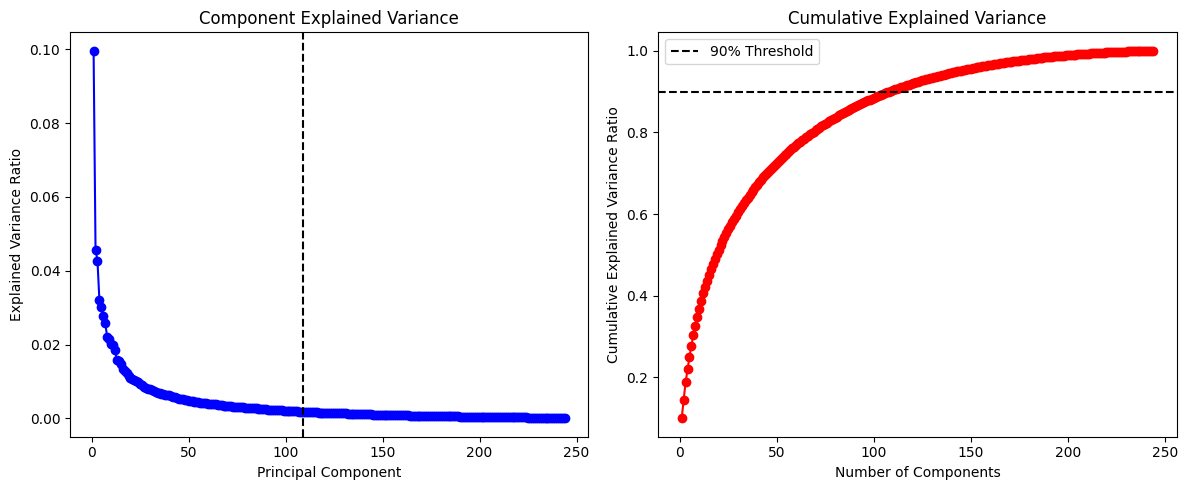

PCA features dataframe shape: (244, 110)


In [5]:
# %% main: 1. Reduce dimensionality using PCA before clustering

features_df_reduced = preprocess_features_PCA(clip_features_df) 
print("PCA features dataframe shape:", features_df_reduced.shape)

Optimal number of clusters: 5


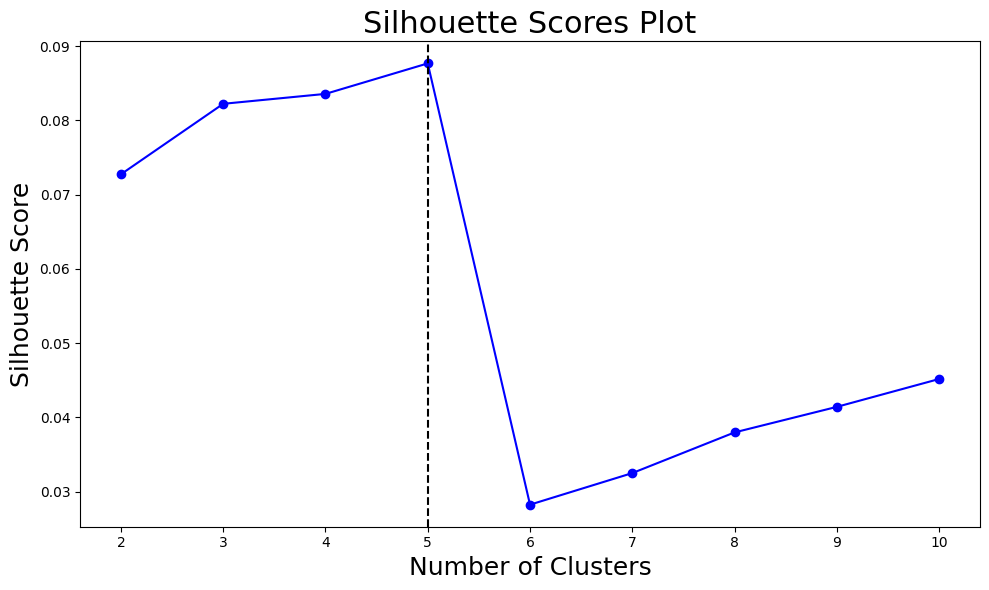

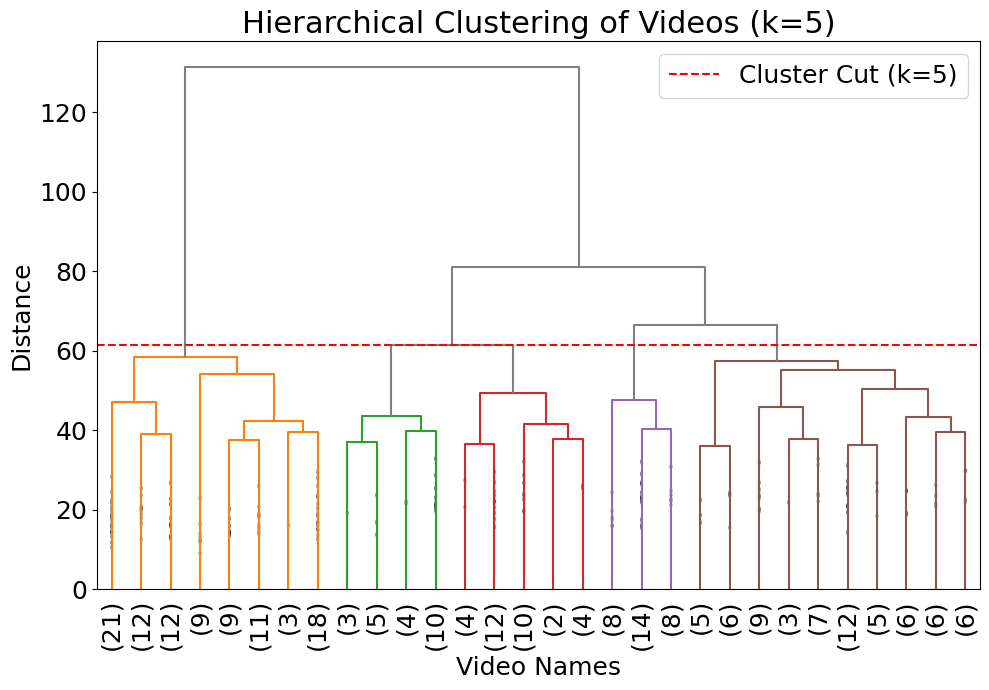

In [6]:
#%% main: 2. Clustering
hc_cluster_labels, hc_silhouette_score = hierarchical_clustering(features_df_reduced,
                                                               n_clusters=None,
                                                               hc_linkage_method="ward",
                                                               hc_criterion="maxclust",
                                                               display=True)

/opt/anaconda3/envs/MACSS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/MACSS/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


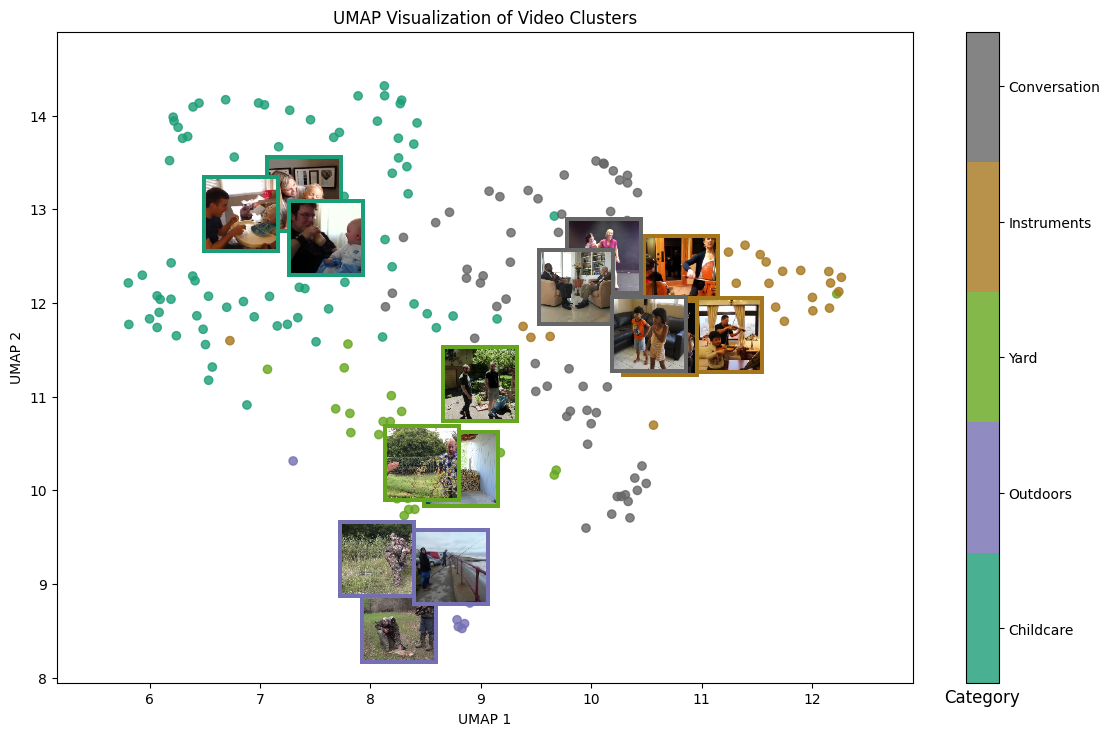


Cluster assignments:
Childcare: 95 videos
Outdoors: 22 videos
Yard: 32 videos
Instruments: 30 videos
Conversation: 65 videos


In [7]:
#%% main: 3. Visualize clusters

# Map cluster labels to interpretable categories
category_mapping = {
    1: 'Childcare',
    2: 'Outdoors', 
    3: 'Yard',
    4: 'Instruments',
    5: 'Conversation'
}

# Visualize clusters using UMAP
visualize_embeddings_umap(features_df_reduced, 
                         video_name_list,
                         hc_cluster_labels, 
                         category_mapping,
                         n_frames=3)

Some interpretable clusters have emerged. Visually dissimilar but semantically similar videos are grouped together, presenting meaningful clusters, indicating that CLIP has the ability to capture high-level information. (Later, more powerful arguments will be made through direct comparison with the visual model.)

In addition, based on these representative videos, we can somehow make sense of the embedding. For example, in these two dimensions, dimension 1 seems to be outdoor-indoor (from bottom to top, from outdoors to yard to indoors), while dimension 2 seems to be transitivity (from left to right, from taking care of children to playing instruments).